In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.198
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.39
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import datetime

tf.random.set_seed(0)
np.random.seed(1)

path = '/content/gdrive/My Drive/Dacon/Jeju/'
path_data = '201901-202003.csv'
path_submission = 'submission.csv'

In [20]:
def read_data_to_dataframe(path):
    return pd.read_csv(path)


def generate_month_list():
  return [int('20190' + str(month)) for month in range(1, 10)] + [int('2019' + str(month)) for month in range(10,13)] + [int('20200' + str(month)) for month in range(1, 5)]


def check_if_submission_set_uniform(submission):
    locations = submission['CARD_SIDO_NM'].unique()
    categories = []
    
    for location in locations:
        if categories:
            if len(categories[0])==len(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])):
                pass
            else:
                categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
        else:
            categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
            
    if len(categories)==1:
        print('submission set is uniform')
        return True, categories[0], locations
    else:
        print('submission set is not uniform')
        return False, None, None


def recall_monthly_spent_hash():
    months = generate_month_list()
    monthly_spent_hash = {}
    for month in months:
        monthly_spent_hash[month] = pd.read_csv(path + str(month) + '.csv')
    return monthly_spent_hash

# location 으로만 어떤 비율인지 df
def XcolumnX_spent_rate_df(monthly_spent_hash, column):
    months = generate_month_list()
    spent_rates_df = pd.DataFrame(columns = months)

    for month in months:
        month_spent = monthly_spent_hash[month]
        locations = list(month_spent[column].unique())
        spent = []
        for location in locations:
            spent.append(month_spent[month_spent[column] == location].dropna()['AMT'].sum())
        denom = sum(spent)/100
        spent_rates = [s/denom for s in spent]
        spent_rates_df[month] = pd.Series(spent_rates, index = locations)

    return spent_rates_df


def spent_rates_mean(spent_rates_df):
    return spent_rates_df.mean(axis = 1)


# 각 지역별로 각 category가 어떤 비율인지 df 로 구하자.
def location_category_mean(monthly_spent_hash, locations, category):
    months = generate_month_list()
    location_category_mean_hash = {}

    for location in locations:
        spent_rates_df = pd.DataFrame(columns = months)
        for month in months:
            month_spent = monthly_spent_hash[month]
            spent = []
            for cate in category:
                spent.append(month_spent[(month_spent['CARD_SIDO_NM'] == location) & (month_spent['STD_CLSS_NM'] == cate)].dropna()['AMT'].sum())
            denom = sum(spent)/100
            spent_rates = [s/denom for s in spent]
            spent_rates_df[month] = pd.Series(spent_rates, index = category)

        location_category_mean_hash[location] = spent_rates_df.mean(axis = 1)

    return location_category_mean_hash


# gdp 출처 : 한국은행「국민소득」 단위 : 십억원, 통계표명 : 국내총생산 및 경제성장률
def gdp_data():
    gdp_df = read_data_to_dataframe(path + 'gdp.csv').dropna().iloc[:, 5:]

    def get_int(data):
        if type(data) == type('a'):
            data = str(data).replace(',', '')
            return float(data)
        else:
            return data

    return gdp_df.applymap(get_int)


# gdp 는 시계열로, 경제성장률은 그대로
def gdp_data4modeling(gdp_df):
    train = [[list(gdp_df.iloc[0, 4 * i:4 * i + 7]),list(gdp_df.iloc[1, 4 * i:4 * i + 7])] for i in range(len(gdp_df.columns) // 4 - 1)]
    for i in range(len(train)):
        denom1 = train[i][0][0]
        train[i][0] = [elt / denom1 - 1 for elt in train[i][0]]
    train = np.array(train)
    train = train.transpose((0,2,1))
    np.random.shuffle(train)
    x_train = train[:,:5,:]
    y_train = train[:,5:,0]

    i = len(gdp_df.columns) // 4 - 1
    denom1 = gdp_df.iloc[0, 4 * i]

    x_res = np.array( gdp_df.iloc[:,4*i:4*i+5] )
    x_res[0] = [elt / denom1 - 1 for elt in x_res[0]]
    x_res = x_res.reshape(1, 2, 5)
    x_res = x_res.transpose((0,2,1))

    return x_train, y_train, x_res, denom1


def gdp_model2predict(x_train, y_train, x_res, denom):
    print('start gdp modeling and prediction')
    model = Sequential()
    model.add(layers.GRU(2, return_sequences=True, input_shape=(5, 2)))
    model.add(layers.GRU(5, return_sequences=False))
    model.add(layers.Dense(2, activation='linear'))
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0)
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    temp = model.predict(x_res)
    gdp_20y2p = (temp[0][0] + 1) * denom
    gdp_20y3p = (temp[0][1] + 1) * denom
    return gdp_20y2p, gdp_20y3p


def prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash):
    result = pd.DataFrame(columns=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT'])
    result.columns.name = 'id'
    gdp_19y2p = gdp_df.loc[0,'20192/4']
    gdp_19y3p = gdp_df.loc[0,'20193/4']

    total1 = monthly_spent_hash[201904]['AMT'].sum() * gdp_20y2p / gdp_19y2p
    total2 = monthly_spent_hash[201907]['AMT'].sum() * gdp_20y3p / gdp_19y3p

    idx = 0
    for location in locations:
        for cate in category:
            temp = total1 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000
            result.loc[idx] = [202004, location, cate, temp]
            idx += 1

    for location in locations:
        for cate in category:
            temp = total2 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000
            result.loc[idx] = [202007, location, cate, temp]
            idx += 1
    thistime = datetime.datetime.now()
    result.to_csv(path + 'submission' + str(thistime) + '.csv')
    print('result has been saved to ','submission' + str(thistime) + '.csv')
    
    return result

def score_test(prediction, april_total):
    from sklearn.metrics import mean_squared_log_error
    predicted_values = np.array(prediction[prediction['REG_YYMM'] == 202004].fillna(0)['AMT'])
    actual_values = np.array(april_total['AMT'])
    return np.sqrt(mean_squared_log_error(predicted_values, actual_values))

submission set is uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


start gdp modeling and prediction


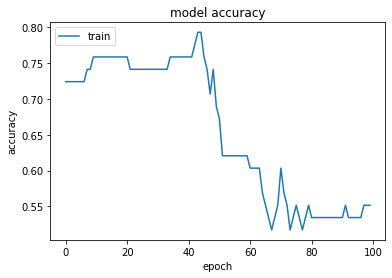

gdp_20y2p, gdp_20y3p :  518068.9122169316 516565.4621838629
result has been saved to  submission2020-07-30 13:10:07.167413.csv
RMSLE : 3.1985637903198607


In [21]:
if __name__ == '__main__':
    submission_path = path + path_submission

    is_uniform, category, locations = check_if_submission_set_uniform(submission = read_data_to_dataframe(submission_path))
    if is_uniform:
        monthly_spent_hash = recall_monthly_spent_hash()

        spent_rates_df = XcolumnX_spent_rate_df(monthly_spent_hash, column = 'CARD_SIDO_NM')
        location_spent_rates_mean = spent_rates_mean(spent_rates_df)
        location_category_mean_hash = location_category_mean(monthly_spent_hash, locations, category)

        gdp_df = gdp_data()
        x_train, y_train, x_res, denom = gdp_data4modeling(gdp_df)
        
        gdp_20y2p, gdp_20y3p = gdp_model2predict(x_train, y_train, x_res, denom)
        print('gdp_20y2p, gdp_20y3p : ',gdp_20y2p, gdp_20y3p)

        prediction = prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash)

        april_total = monthly_spent_hash[202004]

        print('RMSLE :',score_test(prediction, april_total))

SKEWED 되어있는 percentile 을 log1p 를 이용해 옮겨보자.
===========

In [22]:
def read_data_to_dataframe(path):
    return pd.read_csv(path)


def generate_month_list():
  return [int('20190' + str(month)) for month in range(1, 10)] + [int('2019' + str(month)) for month in range(10,13)] + [int('20200' + str(month)) for month in range(1, 5)]


def check_if_submission_set_uniform(submission):
    locations = submission['CARD_SIDO_NM'].unique()
    categories = []
    
    for location in locations:
        if categories:
            if len(categories[0])==len(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])):
                pass
            else:
                categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
        else:
            categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
            
    if len(categories)==1:
        print('submission set is uniform')
        return True, categories[0], locations
    else:
        print('submission set is not uniform')
        return False, None, None


def recall_monthly_spent_hash():
    months = generate_month_list()
    monthly_spent_hash = {}
    for month in months:
        monthly_spent_hash[month] = pd.read_csv(path + str(month) + '.csv')
    return monthly_spent_hash

# location 으로만 어떤 비율인지 df
def XcolumnX_spent_rate_df(monthly_spent_hash, column):
    months = generate_month_list()
    spent_rates_df = pd.DataFrame(columns = months)

    for month in months:
        month_spent = monthly_spent_hash[month]
        locations = list(month_spent[column].unique())
        spent = []
        for location in locations:
            spent.append(month_spent[month_spent[column] == location].dropna()['AMT'].sum())
        denom = sum(spent)/100
        spent_rates = [s/denom for s in spent]
        spent_rates_df[month] = pd.Series(spent_rates, index = locations)

    return spent_rates_df


def spent_rates_mean(spent_rates_df):
    spent_rates_df = spent_rates_df.applymap(np.log1p)
    result = spent_rates_df.mean(axis=1)
    result = result.apply(np.expm1)
    return result


# 각 지역별로 각 category가 어떤 비율인지 df 로 구하자.
def location_category_mean(monthly_spent_hash, locations, category):
    months = generate_month_list()
    location_category_mean_hash = {}

    for location in locations:
        spent_rates_df = pd.DataFrame(columns=months)
        for month in months:
            month_spent = monthly_spent_hash[month]
            spent = []
            for cate in category:
                spent.append(month_spent[(month_spent['CARD_SIDO_NM'] == location) & (
                            month_spent['STD_CLSS_NM'] == cate)].dropna()['AMT'].sum())
            denom = sum(spent) / 100
            spent_rates = [s / denom for s in spent]
            spent_rates_df[month] = pd.Series(spent_rates, index=category)

        spent_rates_df = spent_rates_df.applymap(np.log1p)
        result = spent_rates_df.mean(axis=1)
        result = result.apply(np.expm1)

        location_category_mean_hash[location] = result

    return location_category_mean_hash


# gdp 출처 : 한국은행「국민소득」 단위 : 십억원, 통계표명 : 국내총생산 및 경제성장률 
# http://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=2736
def gdp_data():
    gdp_df = read_data_to_dataframe(path + 'gdp.csv').dropna().iloc[:, 5:]

    def get_int(data):
        if type(data) == type('a'):
            data = str(data).replace(',', '')
            return float(data)
        else:
            return data

    return gdp_df.applymap(get_int)


# gdp 는 시계열로, 경제성장률은 그대로
def gdp_data4modeling(gdp_df):
    train = [[list(gdp_df.iloc[0, 4 * i:4 * i + 7]),list(gdp_df.iloc[1, 4 * i:4 * i + 7])] for i in range(len(gdp_df.columns) // 4 - 1)]
    for i in range(len(train)):
        denom1 = train[i][0][0]
        train[i][0] = [elt / denom1 - 1 for elt in train[i][0]]
    train = np.array(train)
    train = train.transpose((0,2,1))
    np.random.shuffle(train)
    x_train = train[:,:5,:]
    y_train = train[:,5:,0]

    i = len(gdp_df.columns) // 4 - 1
    denom1 = gdp_df.iloc[0, 4 * i]

    x_res = np.array( gdp_df.iloc[:,4*i:4*i+5] )
    x_res[0] = [elt / denom1 - 1 for elt in x_res[0]]
    x_res = x_res.reshape(1, 2, 5)
    x_res = x_res.transpose((0,2,1))

    return x_train, y_train, x_res, denom1


def gdp_model2predict(x_train, y_train, x_res, denom):
    print('start gdp modeling and prediction')
    model = Sequential()
    model.add(layers.GRU(2, return_sequences=True, input_shape=(5, 2)))
    model.add(layers.GRU(5, return_sequences=False))
    model.add(layers.Dense(2, activation='linear'))
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0)
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    temp = model.predict(x_res)
    gdp_20y2p = (temp[0][0] + 1) * denom
    gdp_20y3p = (temp[0][1] + 1) * denom
    return gdp_20y2p, gdp_20y3p


def prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash):
    result = pd.DataFrame(columns=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT'])
    result.columns.name = 'id'
    gdp_19y2p = gdp_df.loc[0,'20192/4']
    gdp_19y3p = gdp_df.loc[0,'20193/4']

    total1 = monthly_spent_hash[201904]['AMT'].sum() * gdp_20y2p / gdp_19y2p
    total2 = monthly_spent_hash[201907]['AMT'].sum() * gdp_20y3p / gdp_19y3p

    idx = 0
    for location in locations:
        for cate in category:
            temp = total1 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000
            result.loc[idx] = [202004, location, cate, temp]
            idx += 1

    for location in locations:
        for cate in category:
            temp = total2 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000
            result.loc[idx] = [202007, location, cate, temp]
            idx += 1
    thistime = datetime.datetime.now()
    result.to_csv(path + 'submission' + str(thistime) + '.csv')
    print('result has been saved to ','submission' + str(thistime) + '.csv')
    
    return result

def score_test(prediction, april_total):
    from sklearn.metrics import mean_squared_log_error
    predicted_values = np.array(prediction[prediction['REG_YYMM'] == 202004].fillna(0)['AMT'])
    actual_values = np.array(april_total['AMT'])
    return np.sqrt(mean_squared_log_error(predicted_values, actual_values))

submission set is uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


start gdp modeling and prediction


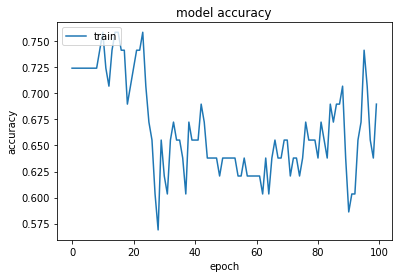

gdp_20y2p, gdp_20y3p :  518928.0342682898 527751.7540430725
result has been saved to  submission2020-07-30 14:32:31.785867.csv
RMSLE : 3.0910929492777974


In [23]:
if __name__ == '__main__':
    submission_path = path + path_submission

    is_uniform, category, locations = check_if_submission_set_uniform(submission = read_data_to_dataframe(submission_path))
    if is_uniform:
        monthly_spent_hash = recall_monthly_spent_hash()

        spent_rates_df = XcolumnX_spent_rate_df(monthly_spent_hash, column = 'CARD_SIDO_NM')
        location_spent_rates_mean = spent_rates_mean(spent_rates_df)
        location_category_mean_hash = location_category_mean(monthly_spent_hash, locations, category)

        gdp_df = gdp_data()
        x_train, y_train, x_res, denom = gdp_data4modeling(gdp_df)
        
        gdp_20y2p, gdp_20y3p = gdp_model2predict(x_train, y_train, x_res, denom)
        print('gdp_20y2p, gdp_20y3p : ',gdp_20y2p, gdp_20y3p)

        prediction = prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash)

        april_total = monthly_spent_hash[202004]

        print('RMSLE :',score_test(prediction, april_total))

소비자심리지수 (CSI) http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1058
출처 : 한국은행 소비자동향조사
============

In [28]:
def read_data_to_dataframe(path):
    return pd.read_csv(path)


def generate_month_list():
  return [int('20190' + str(month)) for month in range(1, 10)] + [int('2019' + str(month)) for month in range(10,13)] + [int('20200' + str(month)) for month in range(1, 5)]


def check_if_submission_set_uniform(submission):
    locations = submission['CARD_SIDO_NM'].unique()
    categories = []
    
    for location in locations:
        if categories:
            if len(categories[0])==len(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])):
                pass
            else:
                categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
        else:
            categories.append(sorted(list(submission[(submission['REG_YYMM'] == 202004) & (submission['CARD_SIDO_NM']==location)].dropna()['STD_CLSS_NM'])))
            
    if len(categories)==1:
        print('submission set is uniform')
        return True, categories[0], locations
    else:
        print('submission set is not uniform')
        return False, None, None


def recall_monthly_spent_hash():
    months = generate_month_list()
    monthly_spent_hash = {}
    for month in months:
        monthly_spent_hash[month] = pd.read_csv(path + str(month) + '.csv')
    return monthly_spent_hash

# location 으로만 어떤 비율인지 df
def XcolumnX_spent_rate_df(monthly_spent_hash, column):
    months = generate_month_list()
    spent_rates_df = pd.DataFrame(columns = months)

    for month in months:
        month_spent = monthly_spent_hash[month]
        locations = list(month_spent[column].unique())
        spent = []
        for location in locations:
            spent.append(month_spent[month_spent[column] == location].dropna()['AMT'].sum())
        denom = sum(spent)/100
        spent_rates = [s/denom for s in spent]
        spent_rates_df[month] = pd.Series(spent_rates, index = locations)

    return spent_rates_df


def spent_rates_mean(spent_rates_df):
    spent_rates_df = spent_rates_df.applymap(np.log1p)
    result = spent_rates_df.mean(axis=1)
    result = result.apply(np.expm1)
    return result


# 각 지역별로 각 category가 어떤 비율인지 df 로 구하자.
def location_category_mean(monthly_spent_hash, locations, category):
    months = generate_month_list()
    location_category_mean_hash = {}

    for location in locations:
        spent_rates_df = pd.DataFrame(columns=months)
        for month in months:
            month_spent = monthly_spent_hash[month]
            spent = []
            for cate in category:
                spent.append(month_spent[(month_spent['CARD_SIDO_NM'] == location) & (
                            month_spent['STD_CLSS_NM'] == cate)].dropna()['AMT'].sum())
            denom = sum(spent) / 100
            spent_rates = [s / denom for s in spent]
            spent_rates_df[month] = pd.Series(spent_rates, index=category)

        spent_rates_df = spent_rates_df.applymap(np.log1p)
        result = spent_rates_df.mean(axis=1)
        result = result.apply(np.expm1)

        location_category_mean_hash[location] = result

    return location_category_mean_hash


# gdp 출처 : 한국은행「국민소득」 단위 : 십억원, 통계표명 : 국내총생산 및 경제성장률 
# http://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=2736
# 2020 1분기까지만 반영하였음.
def gdp_data():
    gdp_df = read_data_to_dataframe(path + 'gdp.csv').dropna().iloc[:, 5:]

    def get_int(data):
        if type(data) == type('a'):
            data = str(data).replace(',', '')
            return float(data)
        else:
            return data

    return gdp_df.applymap(get_int)


# gdp 는 시계열로, 경제성장률은 그대로
def gdp_data4modeling(gdp_df):
    train = [[list(gdp_df.iloc[0, 4 * i:4 * i + 7]),list(gdp_df.iloc[1, 4 * i:4 * i + 7])] for i in range(len(gdp_df.columns) // 4 - 1)]
    for i in range(len(train)):
        denom1 = train[i][0][0]
        train[i][0] = [elt / denom1 - 1 for elt in train[i][0]]
    train = np.array(train)
    train = train.transpose((0,2,1))
    np.random.shuffle(train)
    x_train = train[:,:5,:]
    y_train = train[:,5:,0]

    i = len(gdp_df.columns) // 4 - 1
    denom1 = gdp_df.iloc[0, 4 * i]

    x_res = np.array( gdp_df.iloc[:,4*i:4*i+5] )
    x_res[0] = [elt / denom1 - 1 for elt in x_res[0]]
    x_res = x_res.reshape(1, 2, 5)
    x_res = x_res.transpose((0,2,1))

    return x_train, y_train, x_res, denom1


def gdp_model2predict(x_train, y_train, x_res, denom):
    print('start gdp modeling and prediction')
    model = Sequential()
    model.add(layers.GRU(2, return_sequences=True, input_shape=(5, 2)))
    model.add(layers.GRU(5, return_sequences=False))
    model.add(layers.Dense(2, activation='linear'))
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0)
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    temp = model.predict(x_res)
    gdp_20y2p = (temp[0][0] + 1) * denom
    gdp_20y3p = (temp[0][1] + 1) * denom
    return gdp_20y2p, gdp_20y3p


# 소비자 심리지수 csi 출처 : 한국은행 소비자동향조사
# http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1058
# 4월까지만 반영하였음.
def csi_data():
    return read_data_to_dataframe(path + 'CSI.csv').dropna().iloc[:,1:-3]


def csi_data4modeling(csi_df, n):
    csi_list = list(csi_df.iloc[0,:])
    train = []
    for i in range(len(csi_list) - n - 2):
        temp = csi_list[i:i+n] + [csi_list[i+n+2]]
        denom = temp[0]
        for j in range(len(temp)):
            temp[j] = temp[j] / denom - 1

        train.append(temp)

    train = np.array(train)
    np.random.shuffle(train)
    train = train.reshape((len(train),n+1,1))
    x_train_csi = train[:,:n,:]
    y_train_csi = train[:,n,:]

    x_res_csi = np.array(csi_list[-n:])
    denom_csi = x_res_csi[0]
    for i in range(len(x_res_csi)):
        x_res_csi[i] = x_res_csi[i] / denom_csi - 1

    x_res_csi = x_res_csi.reshape(1,n,1)

    return x_train_csi, y_train_csi, x_res_csi, denom_csi


def csi_model2predict(x_train_csi, y_train_csi, x_res_csi, denom_csi,n):
    model = Sequential()
    model.add(layers.GRU(2, return_sequences=True, input_shape=(n, 1)))
    model.add(layers.GRU(5, return_sequences=False))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_csi, y_train_csi, epochs=100, batch_size=5, verbose=0)
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    temp = model.predict(x_res_csi)
    return (temp[0][0] + 1) * denom_csi


def prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash, ratio1, ratio2):
    result = pd.DataFrame(columns=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT'])
    result.columns.name = 'id'
    gdp_19y2p = gdp_df.loc[0,'20192/4']
    gdp_19y3p = gdp_df.loc[0,'20193/4']

    total1 = monthly_spent_hash[201904]['AMT'].sum() * gdp_20y2p / gdp_19y2p
    total2 = monthly_spent_hash[201907]['AMT'].sum() * gdp_20y3p / gdp_19y3p

    idx = 0
    for location in locations:
        for cate in category:
            temp = total1 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000 * ratio1
            if temp > 0:
                result.loc[idx] = [202004, location, cate, temp]
                idx += 1
            else:
                result.loc[idx] = [202004, location, cate, 0]
                idx += 1

    for location in locations:
        for cate in category:
            temp = total2 * location_spent_rates_mean[location] * location_category_mean_hash[location][cate] / 10000 * ratio2
            if temp > 0:
                result.loc[idx] = [202007, location, cate, temp]
                idx += 1
            else:
                result.loc[idx] = [202007, location, cate, 0]
                idx += 1
    thistime = datetime.datetime.now()
    result.to_csv(path + 'submission' + str(thistime) + '.csv')
    print('result has been saved to ','submission' + str(thistime) + '.csv')
    
    return result

def score_test(prediction, april_total):
    from sklearn.metrics import mean_squared_log_error
    predicted_values = np.array(prediction[prediction['REG_YYMM'] == 202004].fillna(0)['AMT'])
    actual_values = np.array(april_total['AMT'])
    return np.sqrt(mean_squared_log_error(predicted_values, actual_values))

submission set is uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


start gdp modeling and prediction


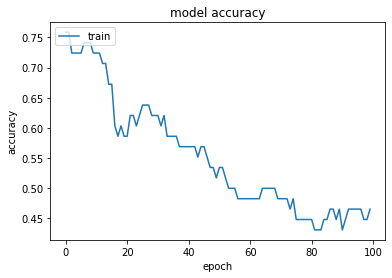

gdp_20y2p, gdp_20y3p :  503916.49239234626 498798.3024607897


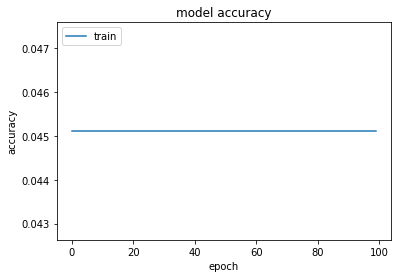

csi_july : 82.31801261305809
result has been saved to  submission2020-07-30 15:42:09.014350.csv
RMSLE : 3.0840663103175716


In [29]:
if __name__ == '__main__':
    submission_path = path + path_submission

    is_uniform, category, locations = check_if_submission_set_uniform(submission = read_data_to_dataframe(submission_path))
    if is_uniform:
        monthly_spent_hash = recall_monthly_spent_hash()

        spent_rates_df = XcolumnX_spent_rate_df(monthly_spent_hash, column = 'CARD_SIDO_NM')
        location_spent_rates_mean = spent_rates_mean(spent_rates_df)
        location_category_mean_hash = location_category_mean(monthly_spent_hash, locations, category)

        gdp_df = gdp_data()
        x_train, y_train, x_res, denom = gdp_data4modeling(gdp_df)
        
        gdp_20y2p, gdp_20y3p = gdp_model2predict(x_train, y_train, x_res, denom)
        print('gdp_20y2p, gdp_20y3p : ',gdp_20y2p, gdp_20y3p)

        csi_df = csi_data()
        x_train_csi, y_train_csi, x_res_csi, denom_csi = csi_data4modeling(csi_df, n = 7)
        csi_july = csi_model2predict(x_train_csi, y_train_csi, x_res_csi, denom_csi, n = 7)
        print('csi_july :',csi_july)
        ratio1 = csi_df.loc[0,'202004월'] / csi_df.loc[0,'201904월']
        ratio2 = csi_july / csi_df.loc[0,'201907월']

        prediction = prediction_df(gdp_df,gdp_20y2p, gdp_20y3p,monthly_spent_hash,locations,category,location_spent_rates_mean,location_category_mean_hash, ratio1, ratio2)

        april_total = monthly_spent_hash[202004]

        print('RMSLE :',score_test(prediction, april_total))

In [32]:
prediction.to_csv(path + 'submissionfinal.csv',encoding='ms949')

In [ ]:
,encoding='euc-kr')